In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sn
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

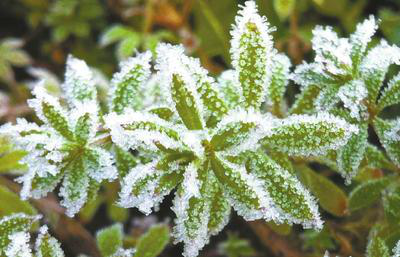

In [3]:
# Open one image from the dataset
path = 'dataset'
with Image.open('dataset/frost/3600.jpg') as img:
    display(img)

In [4]:
# Create a tranform mechanism for each image in the dataset
transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [5]:
# Create ImageFolder Dataset
dataset = datasets.ImageFolder(os.path.join(path), transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 6862
    Root location: dataset
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [47]:
classes = dataset.classes
print(classes)
print("\t")
print("Number of classes:", len(classes))

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Number of classes: 11


In [7]:
# Split dataset into train and test

train_size_old = int(0.85 * len(dataset))
test_size = len(dataset) - train_size_old
train_data_old, test_data = torch.utils.data.random_split(dataset, [train_size_old, test_size])

# Split dataset to train and validation
train_size = int(0.85 * len(train_data_old))
validation_size = len(train_data_old) - train_size

train_data, validation_data = torch.utils.data.random_split(train_data_old, [train_size, validation_size])

In [8]:
# Define the normalization values for mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Apply normalization to the subsets
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
train_data.dataset.transform = train_transform

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_data.dataset.transform = test_transform

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
validation_data.dataset.transform = val_transform

In [44]:
# Create data loaders for each set of data

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True)

print("Training images available", len(train_data))
print("\t")
print("Validation images available", len(validation_data))
print("\t")
print("Testing images available", len(test_data))

Training images available 4957
	
Validation images available 875
	
Testing images available 1030


In [10]:
# Show one tensor from train data
train_data[0]

(tensor([[[ 0.6221,  0.3652, -0.6623,  ..., -0.3198, -0.1314,  1.0331],
          [ 0.6734,  1.0502,  0.8447,  ..., -0.7137, -0.3712,  0.9303],
          [ 0.5364,  0.7591,  1.1187,  ..., -0.7308, -0.6623,  0.4508],
          ...,
          [-1.0733, -0.7650,  0.3481,  ...,  0.3823,  0.2282,  0.5878],
          [-0.4397, -0.4226,  0.3309,  ...,  0.5193,  0.2796,  0.3138],
          [ 0.0741,  0.1768,  0.2453,  ...,  0.7248,  0.3309,  0.3309]],
 
         [[ 0.7829,  0.5203, -0.5651,  ..., -0.1275,  0.1176,  1.3782],
          [ 0.8354,  1.2031,  0.9755,  ..., -0.5476, -0.1275,  1.2206],
          [ 0.6604,  0.8704,  1.2381,  ..., -0.5826, -0.4601,  0.7304],
          ...,
          [-1.0378, -0.7227,  0.4503,  ...,  0.2577,  0.1001,  0.4678],
          [-0.3725, -0.3725,  0.4153,  ...,  0.3803,  0.1176,  0.1527],
          [ 0.1176,  0.2402,  0.3277,  ...,  0.5903,  0.1702,  0.1702]],
 
         [[ 0.7576,  0.4962, -0.5670,  ..., -0.4798, -0.1312,  1.1934],
          [ 0.8099,  1.1759,

Class Indexes: [10  4  1  3  8  7  0  6  3  0  1  2  0  8  9  8]
	
Sample image size: torch.Size([3, 224, 224])


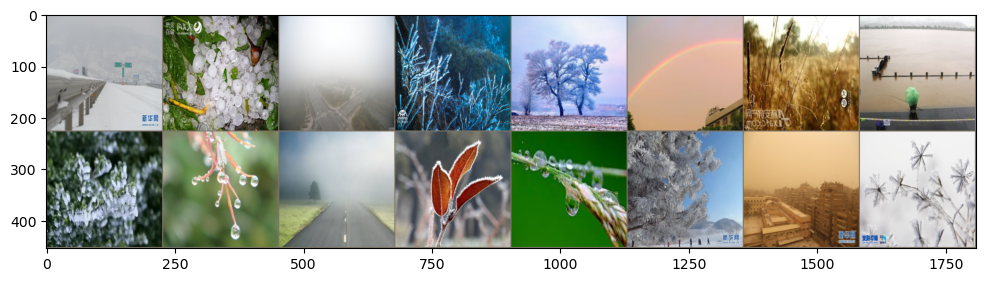

In [55]:
# Grab the first batch of 16 images
for images, labels in train_loader: 
    break

# Print the labels
print('Class Indexes:', labels.numpy())
print("\t")

im = make_grid(images, nrow=8)

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

# Check one image shape
print("Sample image size:", images[10].shape)

In [12]:
# Define the model

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 54*54*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# (((224−2)/2)−2)/2 = 54.5 which rounds down to 54 pixels per side.

In [13]:
# Instantiate the model, define loss and optimization functions

CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(CNNmodel.parameters(), lr=0.001)
print(CNNmodel)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)


In [14]:
# Looking at the trainable parameters
# sum of waits in whole CNN model

def count_parameters(model):
    print("Sum of waits of the model:")
    print("\t")
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
    
count_parameters(CNNmodel)

Sum of waits of the model:
	
     162
       6
     864
      16
 5598720
     120
   10080
      84
     924
      11
________
 5610987


In [15]:
# Train the model

start_time = time.time()
epochs = 10

train_losses = []
train_correct = []
validation_losses = []
validation_correct = []
test_losses = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    validation_corr = 0
    test_corr = 0
    
    # Run the training batches
    for b, (x_train, y_train) in enumerate(train_loader):

        # Apply the model for training
        train_pred = CNNmodel(x_train)
        loss = criterion(train_pred, y_train)
 
        # number of correct predictions
        predicted = torch.max(train_pred.data, 1)[1]
        train_corr += (predicted == y_train).sum()
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    train_losses.append(loss)
    train_correct.append(train_corr)
    
    # Print each epoch results
    print(" Epoch:", i, " Batches per epoch:", b, " Loss:", loss.item())

    
    CNNmodel.eval()
    
    # Run the validation batches
    with torch.no_grad():
        for b, (x_validation, y_validation) in enumerate(validation_loader):
            
            # Apply the model for validation
            val_pred = CNNmodel(x_validation)
            loss = criterion(val_pred, y_validation)

            # number of correct predictions
            predicted = torch.max(val_pred.data, 1)[1] 
            validation_corr += (predicted == y_validation).sum()
            
    validation_losses.append(loss)
    validation_correct.append(validation_corr)
    
    
    
    # Run the test batches
    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(test_loader):
            
            # Apply the model for validation
            test_pred = CNNmodel(x_test)
            loss = criterion(test_pred, y_test)

            # number of correct predictions
            predicted = torch.max(test_pred.data, 1)[1] 
            test_corr += (predicted == y_test).sum()
            
    test_losses.append(loss)
    test_correct.append(test_corr)
    

print("Duration:", time.time() - start_time, "seconds")

 Epoch: 0  Batches per epoch: 309  Loss: 0.8376677632331848
 Epoch: 1  Batches per epoch: 309  Loss: 0.5245270133018494
 Epoch: 2  Batches per epoch: 309  Loss: 0.3517119288444519
 Epoch: 3  Batches per epoch: 309  Loss: 1.0117055177688599
 Epoch: 4  Batches per epoch: 309  Loss: 0.7476125955581665
 Epoch: 5  Batches per epoch: 309  Loss: 0.06145928055047989
 Epoch: 6  Batches per epoch: 309  Loss: 0.24038025736808777
 Epoch: 7  Batches per epoch: 309  Loss: 0.14314764738082886
 Epoch: 8  Batches per epoch: 309  Loss: 0.14512285590171814
 Epoch: 9  Batches per epoch: 309  Loss: 0.2939435839653015
Duration: 1106.3852834701538 seconds


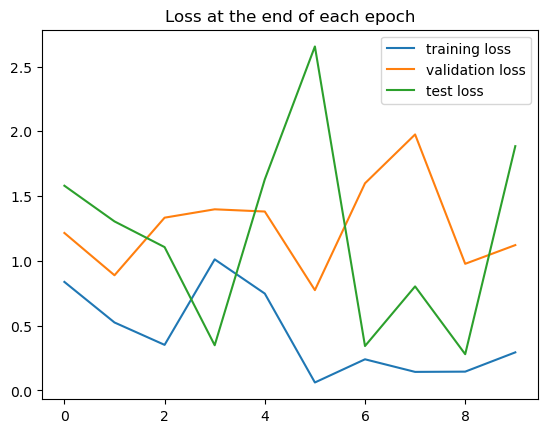

In [31]:
plt.plot([t.detach().numpy() for t in train_losses], label='training loss')
plt.plot([t.detach().numpy() for t in validation_losses], label='validation loss')
plt.plot([t.detach().numpy() for t in test_losses], label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend();

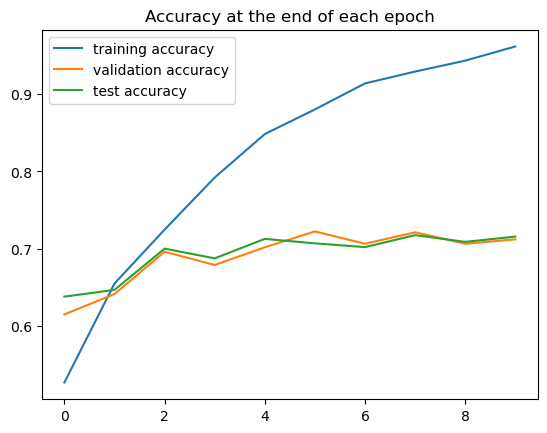

In [32]:
plt.plot([t/4957 for t in train_correct], label='training accuracy')
plt.plot([t/875 for t in validation_correct], label='validation accuracy')
plt.plot([t/1030 for t in test_correct], label='test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [57]:
# Evaluate training, validation and test data
# Accuracy of the last epoch for all data

print("Train Correct:", train_correct)
print("Train Accuracy:", train_correct[-1].item()*100/4957, "%")

print("\t")

print("Validation Correct:", train_correct)
print("Validation Accuracy:", validation_correct[-1].item()*100/875, "%")

print("\t")

print("Test Correct:", train_correct)
print("Test Accuracy:", test_correct[-1].item()*100/1030, "%")

Train Correct: [tensor(2611), tensor(3246), tensor(3592), tensor(3926), tensor(4205), tensor(4363), tensor(4530), tensor(4606), tensor(4676), tensor(4767)]
Train Accuracy: 96.16703651402058 %
	
Validation Correct: [tensor(2611), tensor(3246), tensor(3592), tensor(3926), tensor(4205), tensor(4363), tensor(4530), tensor(4606), tensor(4676), tensor(4767)]
Validation Accuracy: 71.2 %
	
Test Correct: [tensor(2611), tensor(3246), tensor(3592), tensor(3926), tensor(4205), tensor(4363), tensor(4530), tensor(4606), tensor(4676), tensor(4767)]
Test Accuracy: 71.55339805825243 %


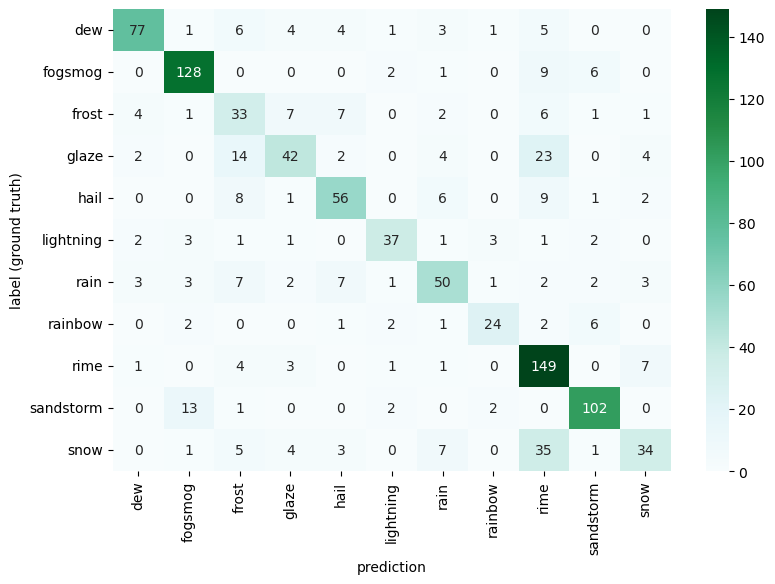

In [21]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=1030, shuffle=False)

with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load_all:
        test_pred = CNNmodel(x_test)
        predicted = torch.max(test_pred,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, classes, classes)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

Custom image size: torch.Size([3, 224, 224])
	
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
	
Predicted Class Index: 0


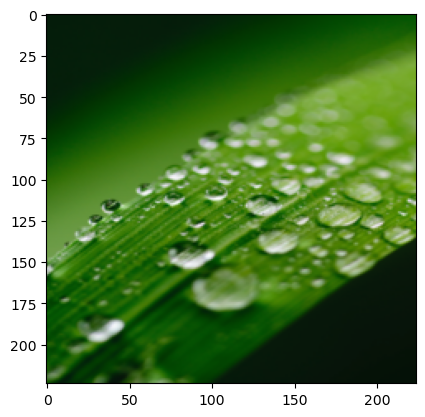

In [54]:
# Open a custom image

custom_img = Image.open('custom_images/2.jpg')

transform_custom = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

custom_img_t = transform_custom(custom_img)
print("Custom image size:", custom_img_t.shape)
print("\t")

custom_img_n = inv_normalize(custom_img_t)
plt.imshow(np.transpose(custom_img_n.numpy(), (1, 2, 0)));

# CNN Model Prediction:
CNNmodel.eval()
with torch.no_grad():
    custom_pred = CNNmodel(custom_img_t.view(1,3,224,224)).argmax()
    
print("Classes:", classes)
print("\t")
print("Predicted Class Index:", custom_pred.item())